# Real Estate Value Estimation

Our goal for this project is to determine if the exterior appearance of a building has predictive power in determining the real estate value of a home. 

We started with Boston property assessment data, which contains many features which can be used to indicate the value of a home. To get an accurate picture of real market value, we scraped sale prices from zillow for a subset of the properties. We scraped Google Street View images for these properties and extracted 25 features which describe qualities of the home and added those features as predictor variables.

# Boston Data

We took a property assessment dataset from data.boston.gov [[source](https://data.boston.gov/dataset/property-assessment/resource/fd351943-c2c6-4630-992d-3f895360febd)]. This dataset contains information which the Boston municipality uses to gague value and set property taxes for buildings.

We kept only the data for residential buildings to avoid inconsistencies across real estate markets, and removed many features which we deemed unnecessary for our purposes. We removed the city's appraised value because these values do not actually track market prices and can be skewed for any number of reasons. We also removed the given building style because we wanted to minimize the redunancy of information provided by the street view images.

This dataset has features which primarily pertain to the building itself. Other than the zipcode, the data contains minimal information about the building's context, which determines much of the building's market value. The lack of information about location makes the value estimation task difficult, but we thought that street view images would give some information about context and would help to fill this gap.

In [1]:
import pandas as pd
boston = pd.read_csv("ast2018full.csv", dtype = {15:str,60:str,63:str})

In [2]:
boston.head()

,PID,CM_ID,GIS_ID,ST_NUM,ST_NAME,ST_NAME_SUF,UNIT_NUM,ZIPCODE,PTYPE,LU,...,U_BTH_STYLE2,U_BTH_STYLE3,U_KITCH_TYPE,U_KITCH_STYLE,U_HEAT_TYP,U_AC,U_FPLACE,U_INT_FIN,U_INT_CND,U_VIEW
0,100001000,NaN,100001000.0,104 A 104,PUTNAM,ST,NaN,2128.0,105,R3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100002000,NaN,100002000.0,197,LEXINGTON,ST,NaN,2128.0,105,R3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100003000,NaN,100003000.0,199,LEXINGTON,ST,NaN,2128.0,105,R3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100004000,NaN,100004000.0,201,LEXINGTON,ST,NaN,2128.0,105,R3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100005000,NaN,100005000.0,203,LEXINGTON,ST,NaN,2128.0,104,R2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
boston.LU = boston.LU.astype("category")

# Remove all data for non-residential buildings
residential_category = ["A","CD","R1","R2","R3","R4","RL"]
residential_bool = [True if x in residential_category else False for x in boston.LU]
residential = boston[residential_bool]

residential = residential.drop(labels = ['MAIL_ADDRESSEE', 'MAIL_ADDRESS', 'MAIL CS', 
                           'MAIL_ZIPCODE','PID', 'CM_ID', 'GIS_ID','OWNER',
                           'S_BLDG_STYL', 'S_UNIT_RES', 'S_UNIT_COM',
                           'S_UNIT_RC', 'S_EXT_FIN', 'S_EXT_CND'], 
                 axis = 1)

In [4]:
#removing rows and columns with only NA's
residential = residential.dropna(axis = 1, how = "all") 
residential = residential.dropna(axis = 0, how = "all") 

After cleaning the data a bit, we need to create a way to easily access the street address so we can pull in other sources of data.

In [5]:
residential["ST_ADDRESS"] = residential['ST_NUM'] + " " + residential['ST_NAME'] + " " + residential['ST_NAME_SUF']

residential = residential.drop_duplicates("ST_ADDRESS")

# Scraping Zillow Data

For scraping our Zillow response variables we used Chris Muir's Zillow's Scraper, which uses Python and Selenium to scrape Zillow postings [[source](https://github.com/ChrisMuir/Zillow)]. This code is contained in several files and opens new instances of Google Chrome, which cannot be done from a Jupyter notebook. Instead, we ran it locally and saved out csv files. We also cleaned the data in excel, which proved to be much faster and easier than doing it from Jupyter.

We used the scraper to scrape sale prices for recently sold homes only, which kept issues of inflation from entering our data. We manually cleaned this data in excel, removing unrealistic sales prices, entries with missing data, and inconsistent address formats.

The final csv holds around 2000 entries.

In [6]:
residential_zillow = pd.read_csv("residential_zillow.csv")

# Scraping Street View Data
Using the Google Street View API, we acquired images from all the properties in our combined dataset. Scraping the images for the 2000 properties took around 3 minutes, but we then had to manually parse through all images and remove images where an invalid image was returned, the image did not contain a picture of the building, or the building was occluded by trees or trucks.

In [9]:
import urllib, os
count = 0
saveDir = r"streetView"
key = "" #redacted

def GetSV (location):
    base = "https://maps.googleapis.com/maps/api/streetview?size=640x480&fov=90&location="
    request = base + urllib.parse.quote_plus(location) + key
    
    # Name the image with the index 
    index = str(count) + ".jpg"
    urllib.request.urlretrieve(request, os.path.join(saveDir, index))

for location in list(residential_zillow.ST_ADDRESS):
    GetSV (location)
    count += 1

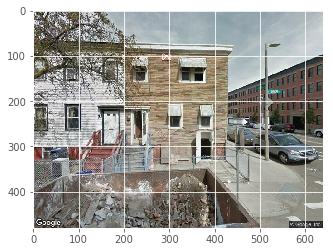

In [13]:
#Example Output
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
im = Image.open("streetView/0.jpg")
plt.imshow(im)

# Architectural Style Dataset

In order to extract useful information about a building from an image, we need to train a machine leaning model to pick up on aspects buildings. One way to do this is to classify architectural style. 

For this, we found a labeled dataset [[source](https://drive.google.com/file/d/0Bwo0SFiZwl3JVGRlWGZUaW5va00/edit)] of 25 architectural styles. These architectural styles do not necessarily line up with the architectural styles from the street view images, but will capture common defining features, so we will simply use the probabilities of each style as an indicator for _some_ style. While this doesn't quite capture style, it does add some information about the underlying features of the 25 styles. 

We found that these raw probabilities had a higher correlation with the market value than the style classification itself.

# Processing Images

In [15]:
import keras
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
import keras.preprocessing.image as KerasImage
import sys

We used the VGG19 model to process images.  The model can be downloaded through Keras with the weights pretrained on the imagenet dataset. You can read more about the model [here](https://arxiv.org/pdf/1409.1556.pdf). 

The model was originally trained to classify objects like cats and dogs, which isn't the task on hand. However, we can still use the model to process our images and output useful vectors.

We can modify the model relatively easily with Keras, which allows us to strip the classifying layers from the model and use a custom input image vector to 

In [16]:
model = VGG19(include_top=False, input_shape=(800,600,3))

The default model outputs a four dimensional array, so we'll have to flatten that into a 1d vector in order to properly interface with the outputs later on

In [17]:
output = model.get_layer('block5_pool').output
output = keras.layers.Flatten()(output)
model = keras.models.Model(model.input, output)

Our architectural style dataset was organized such that each unique style classification had its own folder containing the images which belonged to that class. 

The following code traverses the parent folder, pushes each image through the VGG model, and labels the resulting vectors with the appropriate class.

In [20]:
# Open the specified folder and get all the subdirectories
dname = "D:\\DataScience\\arcDataset"
sdnames = os.listdir(dname)

# Set up dummy arrays to hold the processed features and labels 
y = np.array([-1])
X = np.array([i for i in range(230400)])

count = 0

for i in range(len(sdnames):
    sdname = sdnames[i] + '/'
               
    # Ignore non-directory files 
    try: fnames = os.listdir(dname + sdname)
    except: continue
               
    for j in range(len(fnames)):
        fname = dname + sdname + fnames[j]
        
        # Ignore non-image files
        try: im = KerasImage.load_img(fname, target_size=(800,600))
        except: continue
               
        # Print out a message to show progression 
        count += 1
        sys.stdout.write("\rsdir: " + str(i) + " im: " + str(j))
        sys.stdout.flush()
               
        # Format image properly
        im = KerasImage.img_to_array(im)
        im = np.expand_dims(im, axis=0)
        
        # Push image through the model
        im = preprocess_input(im)
        im = model.predict(im)
        
        # Correct shape of output vector
        im = np.squeeze(im)
        
        # Add vector to X and label to y
        X = np.append(X, im, axis=0)
        y = np.append(y, np.array([i]), axis=0)

# Delete the placeholder vectors
X = np.delete(X, range(230400), axis=0)
y = np.delete(y, 0, axis=0)

# Reshape the features               
X = X.reshape(count, 230400)

We went through a similar process for our street view images. The code is nearly identical, just with a few lines commented out because the data was unlabeled and because we did not need to traverse a file structure in the same way. We've omitted this code for the sake of brevity.


To avoid unneccessarily running this compute-heavy code, we saved out the results as pickle files, which we loaded as necessary.

#Logistic Regression for Style Classification

We took the 230,400 feature vectors output from VGG19 and trained a logistic regression model on the architectural style dataset to classify style. We then used the trained model to output the raw class probabilities of the street view images.

In [21]:
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import GradientBoostingRegressor
import scipy.stats

In [22]:
with open('arcDataX.pickle', 'rb') as file:
    X = pickle.load(file)
with open('arcDatay.pickle', 'rb') as file:
    y = pickle.load(file)

In [23]:
# Split the data into train, validate, and test sets
X_arctr, X_arctest, y_arctr, y_arctest = train_test_split(X, y, test_size=0.3, random_state=5)
X_arctest, X_arcval, y_arctest, y_arcval = train_test_split(X_arctest, y_arctest, test_size=0.5, random_state=5)

The logistic regression gave a reasonably good fit without modifying much. In the end, since we aren't _really_ classifying architectural style, this seemed reasonable enough to leave as is.

In [24]:
model_arc = LR(random_state = 0, dual=False, max_iter=3000)
model_arc.fit(X_arctr, y_arctr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=3000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [29]:
model_arc.score(X_arcval, y_arcval)

0.702928870292887

# Adding Features to Original Dataset

Now that we have our logistic regression model trained, we need to combine all of our features.

In [30]:
# Load VGG19 outputs for street view images
import pickle
with open('streetViewX.pickle', 'rb') as file:
    X_SV = pickle.load(file)
with open('streetViewy.pickle', 'rb') as file:
    y_SV = pickle.load(file)

After sifting through the street view images, we came across a number that were not useful for our purposes. Since this happened outside of the scope of our Jupyter notebook, we need to make sure we are only operating on entries with valid street view data.

In [31]:
# Indexed with valid images
df_final = residential_zillow.iloc()[y_SV.astype(int)]

Now we need to get the 25 style classification probabilities and insert them as features in our dataset.

In [32]:
# Run the logistic regression model on the street view images
X_SVC = model_arc.predict_proba(X_SV)

X_SVCdf = pd.DataFrame(data=X_SVC, index=y_SV);
X_SVCdf.index = X_SVCdf.index.astype(int)
df_final = pd.concat([df_final, X_SVCdf], axis=1)

And now some final data cleaning..

In [33]:
y_final = df_final['SALE_PRICE']

X_final = df_final.drop('SALE_PRICE', axis=1)
X_final = X_final.drop(['ST_NUM', 'ST_NAME', 'ST_NAME_SUF', 'AV_LAND', 'AV_BLDG', 'AV_TOTAL', 'GROSS_TAX', 'ST_ADDRESS','PTYPE'], axis=1)

X_final = pd.get_dummies(X_final, columns=['R_BLDG_STYL','LU','OWN_OCC','STRUCTURE_CLASS','R_ROOF_TYP','R_EXT_FIN','R_EXT_CND','R_BTH_STYLE',\
                                           'R_BTH_STYLE2','R_BTH_STYLE3','R_KITCH_STYLE','R_KITCH_STYLE2','R_KITCH_STYLE3','R_HEAT_TYP','R_AC',\
                                           'R_OVRALL_CND','R_INT_CND','R_INT_FIN','R_VIEW'])

X_final = X_final.astype(np.float32).fillna(0)

X_final = X_final.drop('Unnamed: 0', axis=1).reset_index(drop=True)
y_final = y_final.reset_index(drop=True)

As we can see below, the features from the street view images are the most highly correlated with the market value of the homes.

In [39]:
# Print the pearson correlation of the market value and all features in the X_final dataframe
dict(X_final.assign(Value=y_final.squeeze()).apply(lambda x : pd.factorize(x)[0]).corr(method='pearson')['Value'])

{'ZIPCODE': 0.07971393541609594,
 'LAND_SF': 0.2631687906272019,
 'YR_BUILT': 0.05311764283932073,
 'YR_REMOD': 0.06051883542046775,
 'GROSS_AREA': 0.3015674236221527,
 'LIVING_AREA': 0.30326966982892256,
 'NUM_FLOORS': 0.07215304998592013,
 'R_TOTAL_RMS': -0.009427871194288392,
 'R_BDRMS': -0.014479246075251485,
 'R_FULL_BTH': 0.013468400044047472,
 'R_HALF_BTH': 0.005019064686026373,
 'R_KITCH': -0.05505407841310702,
 'R_FPLACE': 0.07862457812650979,
 0: 0.37145694930873796,
 1: 0.37145694930873796,
 2: 0.37145694930873796,
 3: 0.37145694930873796,
 4: 0.37145694930873796,
 5: 0.37145694930873796,
 6: 0.37145694930873796,
 7: 0.37145694930873796,
 8: 0.37145694930873796,
 9: 0.37145694930873796,
 10: 0.37145694930873796,
 11: 0.37145694930873796,
 12: 0.37145694930873796,
 13: 0.37145694930873796,
 14: 0.37145694930873796,
 15: 0.37145694930873796,
 16: 0.37145694930873796,
 17: 0.37145694930873796,
 18: 0.37145694930873796,
 19: 0.37145694930873796,
 20: 0.37145694930873796,
 21: 0.

In [40]:
# Split into train, validate, and test sets
X_finaltr, X_finaltest, y_finaltr, y_finaltest = train_test_split(X_final, y_final, test_size=0.3, random_state=5)
X_finaltest, X_finalval, y_finaltest, y_finalval = train_test_split(X_finaltest, y_finaltest, test_size=0.5, random_state=5)

We'll also want to drop the features taken from the street view images and use the remaining data as a baseline test

In [43]:
X_nSV = X_final.drop(labels=list(range(25)), axis=1)
y_nSV = y_final

In [44]:
X_nSVtr, X_nSVtest, y_nSVtr, y_nSVtest = train_test_split(X_nSV, y_nSV, test_size=0.3, random_state=5)
X_nSVtest, X_nSVval, y_nSVtest, y_nSVval = train_test_split(X_nSVtest, y_nSVtest, test_size=0.5, random_state=5)

## Cross-Validating Hyperparameters

We applied cross validation on our Gradient Boosting Regressor model to acquire the best parameters. Below we show an example but when we were finding the best parameters we ran 5 trials for each value we wanted to try. We applied cross validation on n_estimators, loss, learning_rate, max_depth, subsample, and alpha. For each parameter we took the value that resulted with the best score and added it to our model as we continue testing through the rest of our parameters.

In [45]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse

In [46]:
to_try = [2,3,1]
numTrials = 5
best = 0
bestVal = 0
for val in to_try: 
    score = 0
    for i in range(numTrials):
        GBR = GradientBoostingRegressor(n_estimators = 2000, loss='quantile', learning_rate=.014, max_depth=2,\
                                    subsample=.99,alpha=.89)
        GBR.fit(X_nSVtr, y_nSVtr.squeeze())
        curScore = GBR.score(X_nSVval, y_nSVval.squeeze())
        score += curScore
        print("testing " + str(val) + " - score: " + str(curScore))
    score /= 3
    print("avg for " + str(val) + ": " + str(score))
    if score > best: 
        best = score
        bestVal = val
print("best choice is: " + str(bestVal))

# Gradient Boosted Regressor

In [57]:
GBR = GradientBoostingRegressor(n_estimators = 2000, loss='quantile', learning_rate=.014, max_depth=2,\
                            subsample=.99,alpha=.89)
GBR.fit(X_finaltr, y_finaltr.squeeze())
GBR.score(X_finalval, y_finalval.squeeze())

0.7874182918407084

In [52]:
GBRnSV = GradientBoostingRegressor(n_estimators = 2000, loss='quantile', learning_rate=.014, max_depth=2,\
                                    subsample=.99,alpha=.89)
GBRnSV.fit(X_nSVtr, y_nSVtr)

GBRnSV.score(X_nSVval, y_nSVval.squeeze())

0.3697081772029398

In [55]:
GBR.score(X_finaltest, y_finaltest.squeeze())

0.8005829865674475

In [63]:
print("MSE with street view:" + "    " + str(mse(y_finalval.squeeze(), GBR.predict(X_finalval))))
print("MSE without street view: " + str(mse(y_nSVval.squeeze(), GBRnSV.predict(X_nSVval))))

MSE with street view:    240147479298.47305
MSE without street view: 712022656030.8505


Below we run Kruskal-Wallis H-Test to further analyze our model's output. We compare our predicted values and the true values to determine if they achieved similar population medians. The predicted values and the true values for both models, with Street View and without Streeet View, differ significantly with p-values smaller than 0.0001. However, the population medians of our predictions from the model with Street View and without Street View do not significantly differ.

In [75]:
print(scipy.stats.kruskal(GBRnSV.predict(X_nSVtest), y_nSVtest))
print(scipy.stats.kruskal(GBR.predict(X_finaltest),y_finaltest))
print(scipy.stats.kruskal(GBR.predict(X_finaltest),GBRnSV.predict(X_nSVtest)))

KruskalResult(statistic=93.19644728214197, pvalue=4.735303831197981e-22)
KruskalResult(statistic=95.7527243278832, pvalue=1.3016725348993482e-22)
KruskalResult(statistic=0.1309185063230691, pvalue=0.7174815946761984)


In [76]:
scipy.stats.kruskal((GBRnSV.predict(X_nSVtest), y_nSVtest),(y_finaltest,y_finaltest))

KruskalResult(statistic=875787.2142043461, pvalue=0.0)

# Conclusion

Our model can more accurately predict a property's Sale Value when provided information acquired from Google Street View images. The model goes from approximately 36% accuracy to approximately 79% accurracy when Street View images are included. When we look at the specific correlations between Street View Images and our response variable Value we see that the Street View Images have the highest correlation with Value.